In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import interp2d
from src.cp_hw2 import *

/home/aramesh/anaconda3/envs/comp-photo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plen_im = cv2.imread('./data/chessboard_lightfield.png',-1)[:,:,::-1]

In [4]:
# Creating 5 dimensional light-field representation
L = np.zeros([16,16,plen_im.shape[0]//16,plen_im.shape[1]//16,plen_im.shape[2]])

for Li in range(16) :
    for Lj in range(16) : 
        for ui in range(Li,plen_im.shape[0],16) : 
            for vi in range(Lj,plen_im.shape[1],16) : 
                L[Li, Lj, ui//16, vi//16] = plen_im[ui, vi]

L = L.astype('int')
L_org = L.copy()
L = L_org[:,:,::1,::1,:]

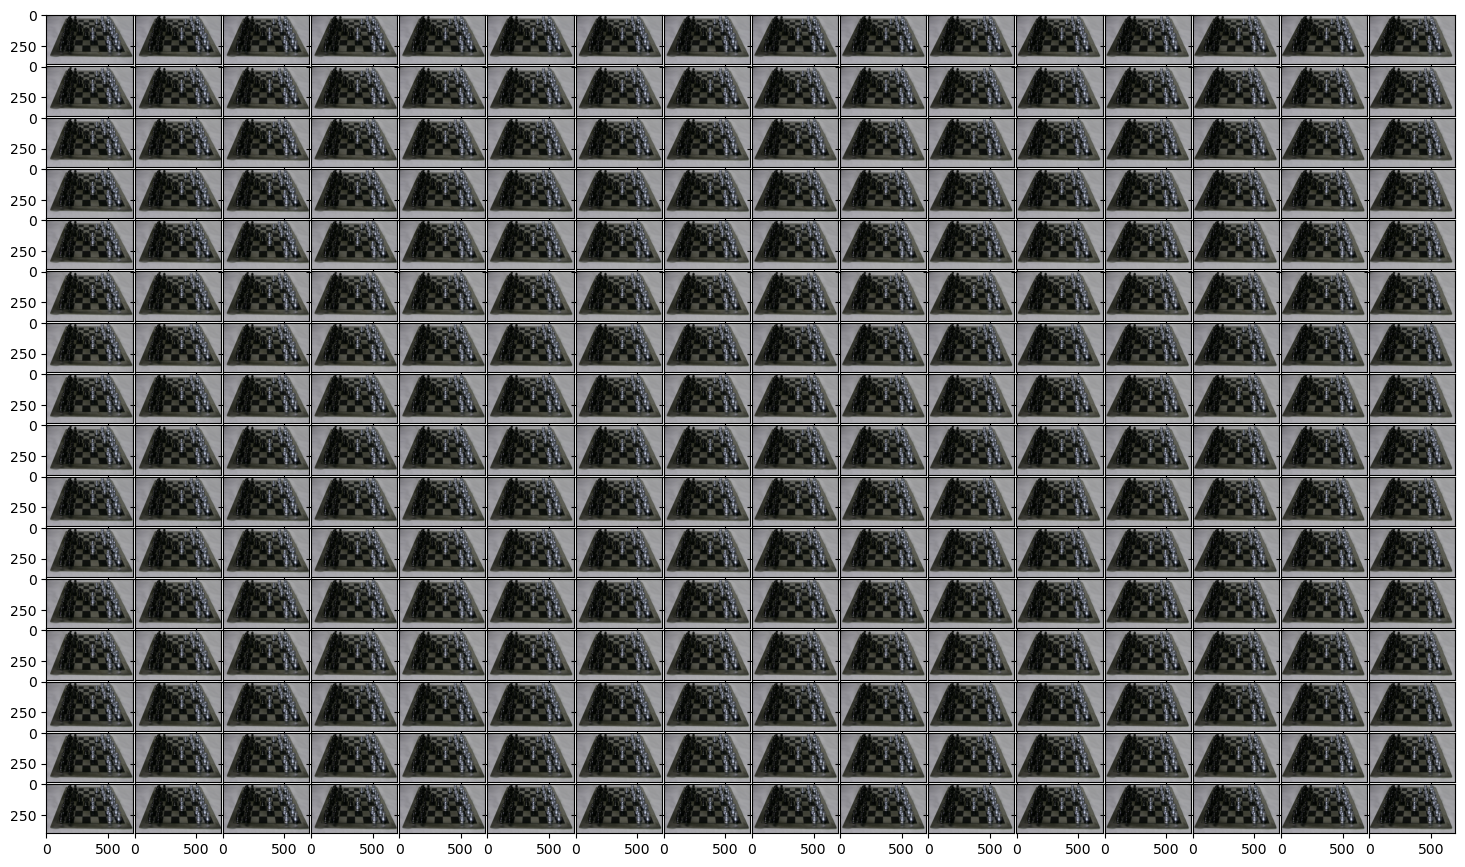

In [5]:
# displaying sub-aperture grid
fig = plt.figure(figsize=(40, 40))
im_grid = ImageGrid(fig, 121, (16,16))
grid_count = 0
for ui in range(16) :
    for vi in range(16) : 
        im_grid[grid_count].imshow(L[ui,vi])
        grid_count += 1
        
plt.show()

In [6]:
# Refocusing
lensletSize = 16
maxUV = (lensletSize - 1) / 2
u = np.arange(lensletSize) - maxUV
v = -( np.arange(lensletSize) - maxUV )

# d = 0
L_largest_aperture = np.zeros(L[0][0].shape)
L_largest_aperture = np.sum(np.sum(L,0),0) / (16*16)
# for i in range(L.shape[2]) : 
#     for j in range(L.shape[3]) :
#         L_largest_aperture[i,j,0] = np.sum(L[:,:,i,j,0]) / (16*16)
#         L_largest_aperture[i,j,1] = np.sum(L[:,:,i,j,1]) / (16*16)
#         L_largest_aperture[i,j,2] = np.sum(L[:,:,i,j,2]) / (16*16)
        
# d all
d_arr = [-2,-1,-0.75,-0.5,-0.25,-0.1,0,0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2]
I = np.zeros([L[0][0].shape[0],L[0][0].shape[1],L[0][0].shape[2],len(d_arr)])

# steps
# 1) create all the shifted images
# 2) while combining the images, create masks for A to determine what gets in and what doesn't

L_interp = []
for i in range(16) :
    for j in range(16) : 
        temp = []
        temp.append(interp2d(np.arange(L.shape[3]),np.arange(L.shape[2]),L[i,j,:,:,0]))
        temp.append(interp2d(np.arange(L.shape[3]),np.arange(L.shape[2]),L[i,j,:,:,1]))
        temp.append(interp2d(np.arange(L.shape[3]),np.arange(L.shape[2]),L[i,j,:,:,2]))
        L_interp.append(temp)

for di, d in enumerate(d_arr) : 
    print(di)
    temp = np.zeros(L[0][0].shape)
    for ui, uc in zip(np.arange(16),u) : 
        for vi, vc in zip(np.arange(16),v) : 
            cur_fun = L_interp[ui*16+vi]
            temp[:,:,0] += cur_fun[0](np.arange(L.shape[3])+d*vc, np.arange(L.shape[2])+d*uc)
            temp[:,:,1] += cur_fun[1](np.arange(L.shape[3])+d*vc, np.arange(L.shape[2])+d*uc)
            temp[:,:,2] += cur_fun[2](np.arange(L.shape[3])+d*vc, np.arange(L.shape[2])+d*uc)
    I[:,:,:,di] = temp.copy() / (16*16)

I = I / 255 # normalize to 0-1 range

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


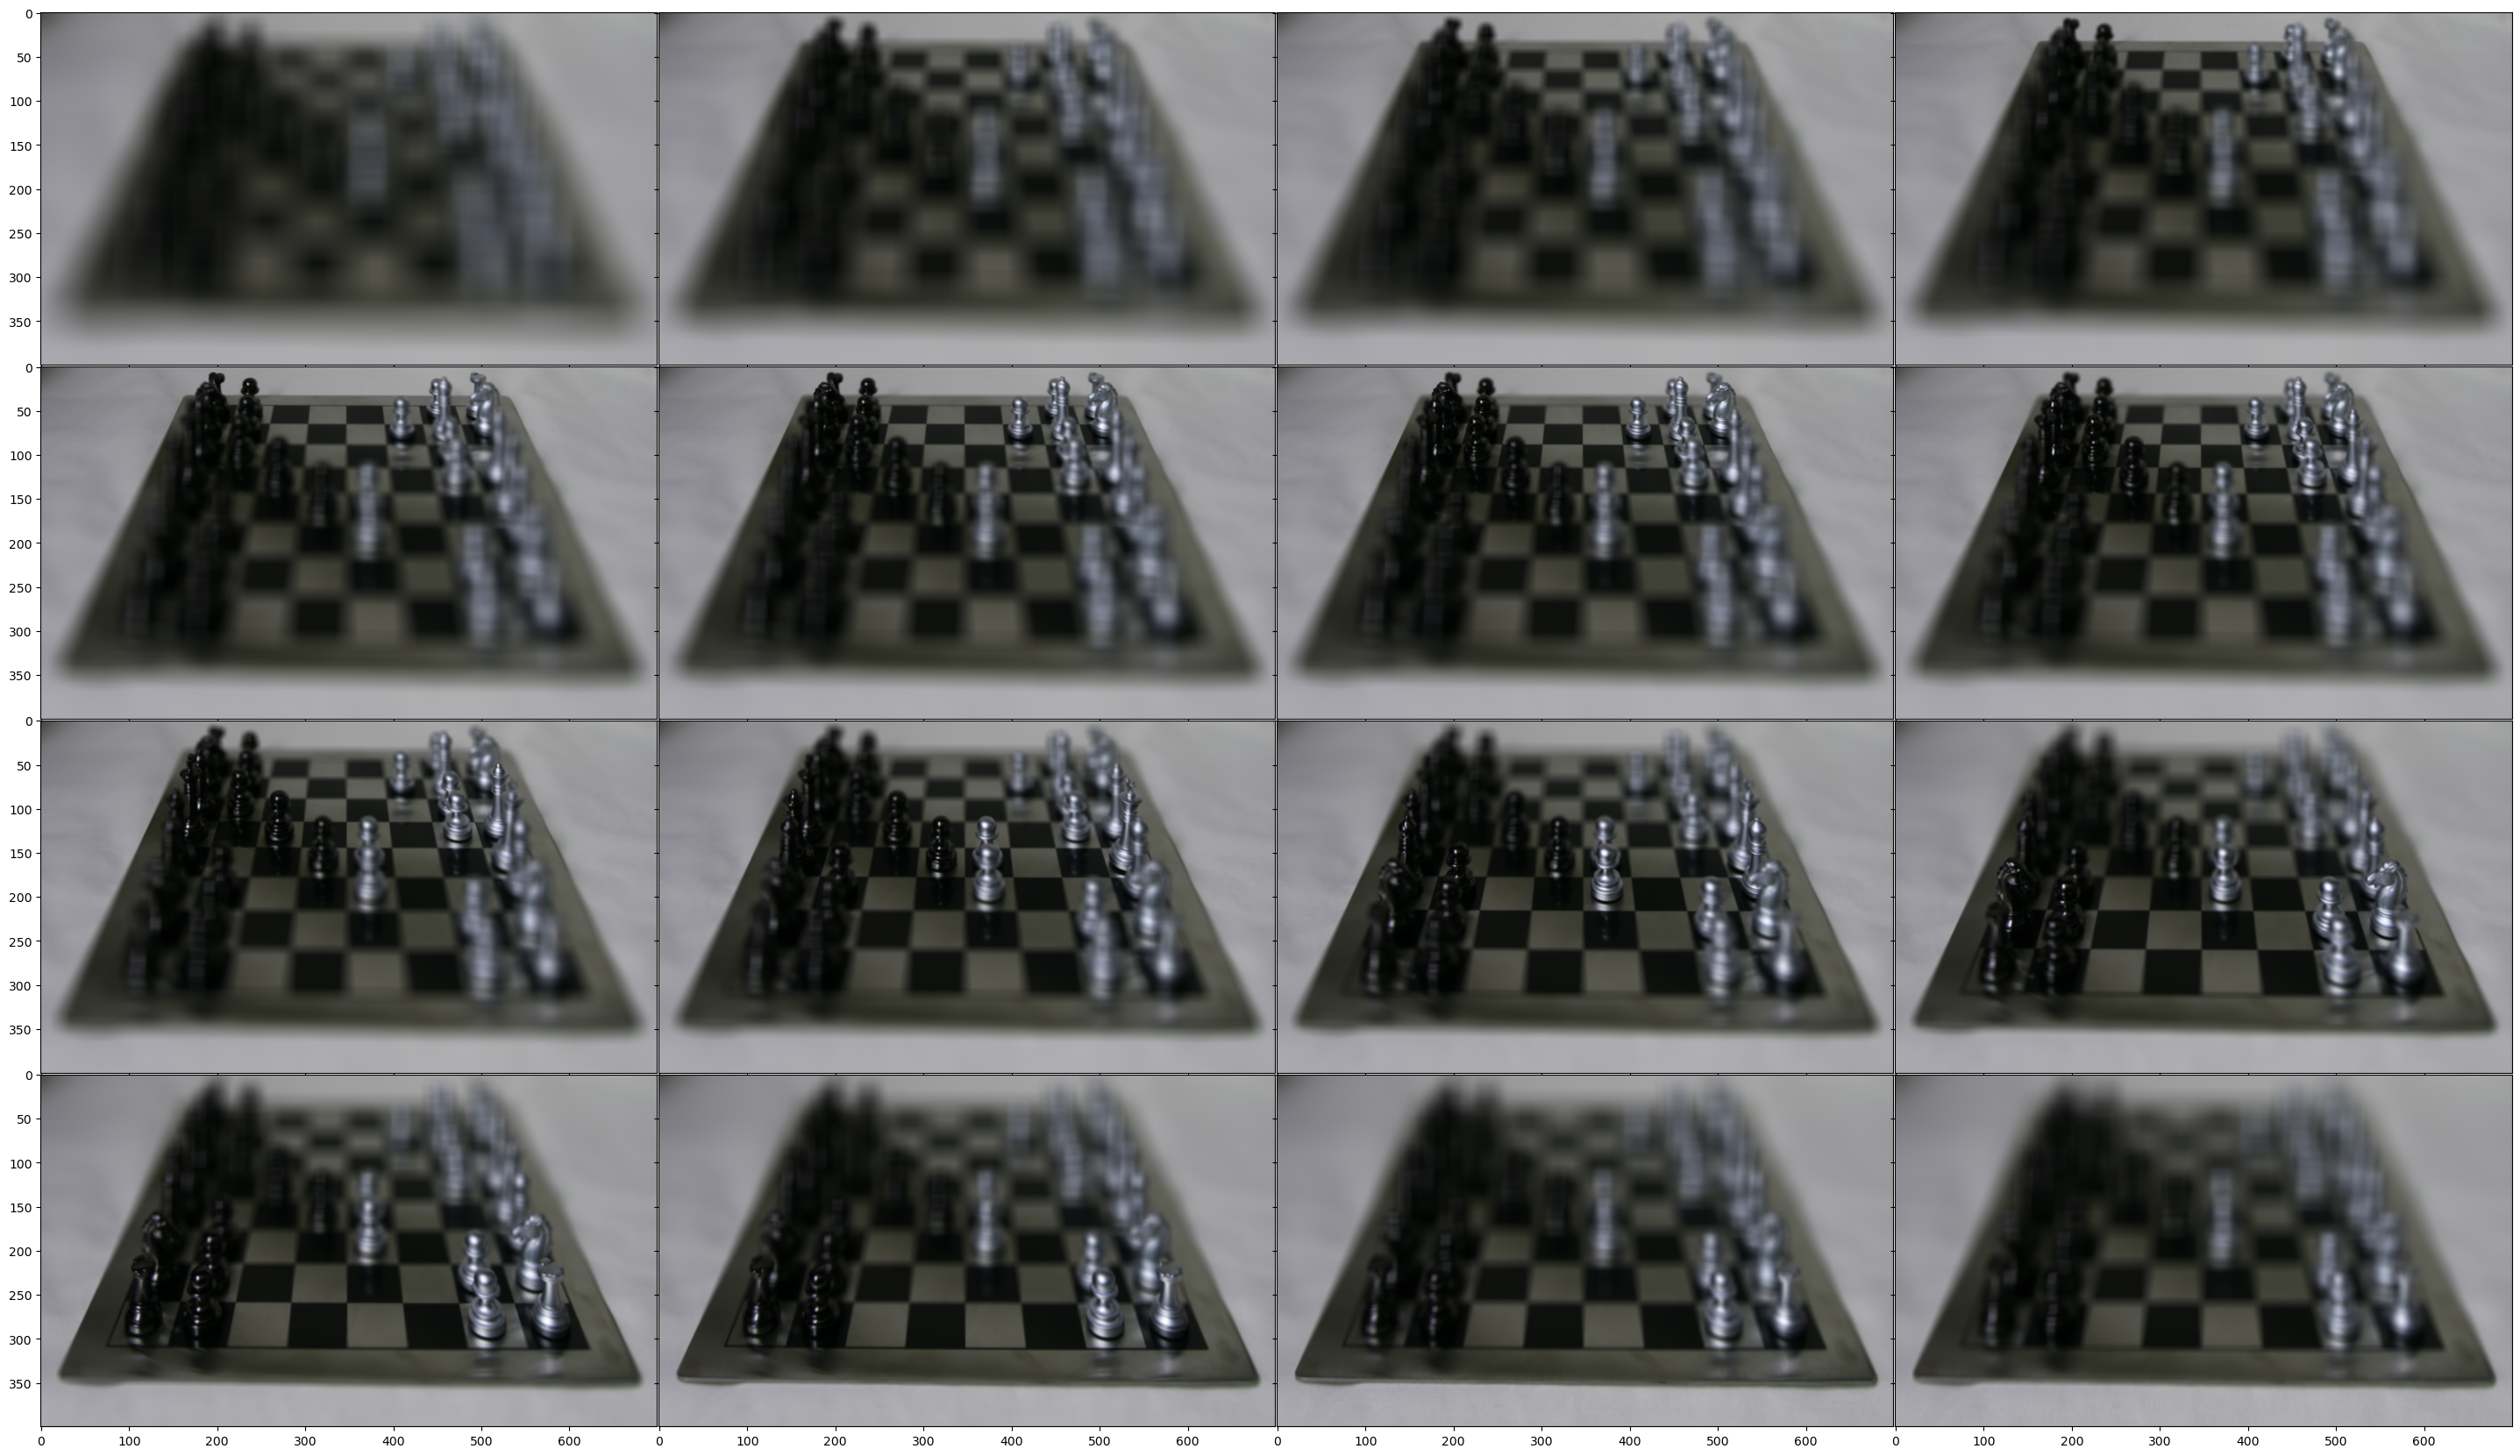

In [7]:
# displaying focal grid
fig = plt.figure(figsize=(80, 80))
im_grid = ImageGrid(fig, 121, (4,4))
for di in range(len(d_arr)) :
        im_grid[di].imshow(I[:,:,:,di])
        
plt.show()

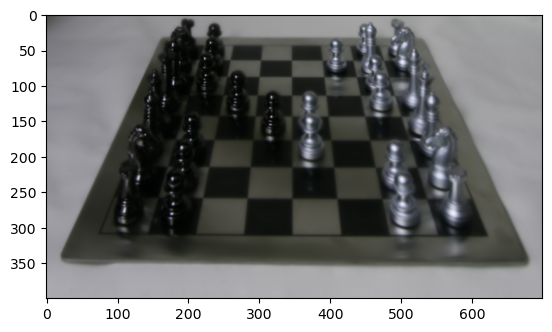

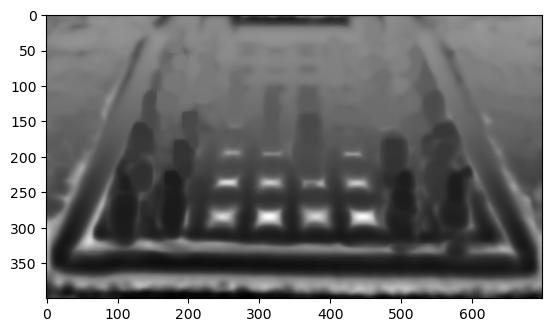

In [13]:
# All in-focus image and depth from focus

# Step 1 ) 
# Linearize by applying removing the gamma encoding
# Convert to XYZ from linear RGB

@np.vectorize
def linearize_image(C_nonlinear) : 
    
    if C_nonlinear <= 0.0404482 : 
        return C_nonlinear / 12.92
    else : 
        out_num = ( C_nonlinear + 0.055 ) ** 2.4
        out_den = 1.055 ** 2.4
        
        return out_num / out_den
    
I_linear = linearize_image(I)
I_XYZ = np.zeros(I_linear.shape)
for foc_im in range(I_linear.shape[-1]) : 
    I_XYZ[:,:,:,foc_im] = lRGB2XYZ(I_linear[:,:,:,foc_im])
I_luminance = I_XYZ[:,:,1,:] # take just Y channel for relative luminance 

kernel_size = [21,21]
sigma1 = 50
sigma2 = 5

I_luminance_lowfreq = cv2.GaussianBlur(I_luminance,kernel_size,sigma1)

I_luminance_highfreq = I_luminance - I_luminance_lowfreq

w_sharpness = cv2.GaussianBlur(I_luminance_highfreq**2, kernel_size, sigma2)

I_all_in_focus = np.zeros([I.shape[0],I.shape[1],I.shape[2]])
I_all_in_focus[:,:,0] = np.sum(w_sharpness * I[:,:,0,:], -1) / np.sum(w_sharpness,-1)
I_all_in_focus[:,:,1] = np.sum(w_sharpness * I[:,:,1,:], -1) / np.sum(w_sharpness,-1)
I_all_in_focus[:,:,2] = np.sum(w_sharpness * I[:,:,2,:], -1) / np.sum(w_sharpness,-1)

plt.imshow(I_all_in_focus)
plt.show()

num = np.zeros([I_all_in_focus.shape[0],I_all_in_focus.shape[1]])
den = np.zeros([I_all_in_focus.shape[0],I_all_in_focus.shape[1]])
for foc_im in range(I_linear.shape[-1]) : 
    num += w_sharpness[:,:,foc_im] * d_arr[foc_im]
    den += w_sharpness[:,:,foc_im]
depth_im = num / den

plt.imshow(1-depth_im,cmap='gray')
plt.show()

In [14]:
# Focal aperture stack and confocal stereo
sides_array = [2,4,6,8,10,12,14,16]
I_fas = np.zeros([L[0][0].shape[0],L[0][0].shape[1],L[0][0].shape[2],len(d_arr), len(sides_array)])
for si, side in enumerate(sides_array) :
    print(si)
    for di, d in enumerate(d_arr) : 
        temp = np.zeros(L[0][0].shape)
        for ui, uc in zip(np.arange(16),u) : 
            if np.abs(uc) > side/2 :  continue
            for vi, vc in zip(np.arange(16),v) : 
                if np.abs(vc) > side/2 : continue
                cur_fun = L_interp[ui*16+vi]
                temp[:,:,0] += cur_fun[0](np.arange(L.shape[3])+d*vc, np.arange(L.shape[2])+d*uc)
                temp[:,:,1] += cur_fun[1](np.arange(L.shape[3])+d*vc, np.arange(L.shape[2])+d*uc)
                temp[:,:,2] += cur_fun[2](np.arange(L.shape[3])+d*vc, np.arange(L.shape[2])+d*uc)
        I_fas[:,:,:,di,si] = temp.copy() / (side*side)
    
I_fas = I_fas / 255

0
1
2
3
4
5
6
7


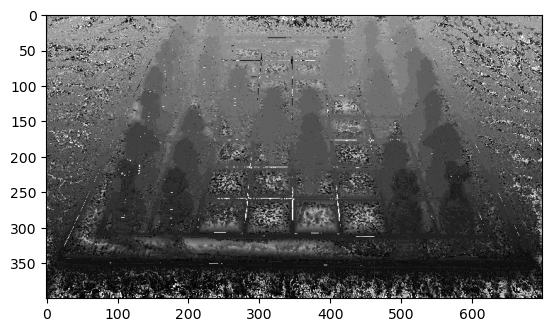

In [15]:
# AFI stack should be for every pixel, find ideal focus. This ideal focus corresponds to pixel depth. 
# unlike the paper, and the assignment, our rows correspond to focus, and cols to apertures.
# so we need to find best row. 
depth_Ifas = np.zeros([I_fas.shape[0], I_fas.shape[1]])

for i in range(I_fas.shape[0]) : 
    for j in range(I_fas.shape[1]) : 
        f_star_index = np.argmin(np.sum(np.var(I_fas[i,j,:],-1),0))
        depth_Ifas[i,j] = d_arr[f_star_index]
        
plt.imshow(1-depth_Ifas,cmap='gray')
plt.show()

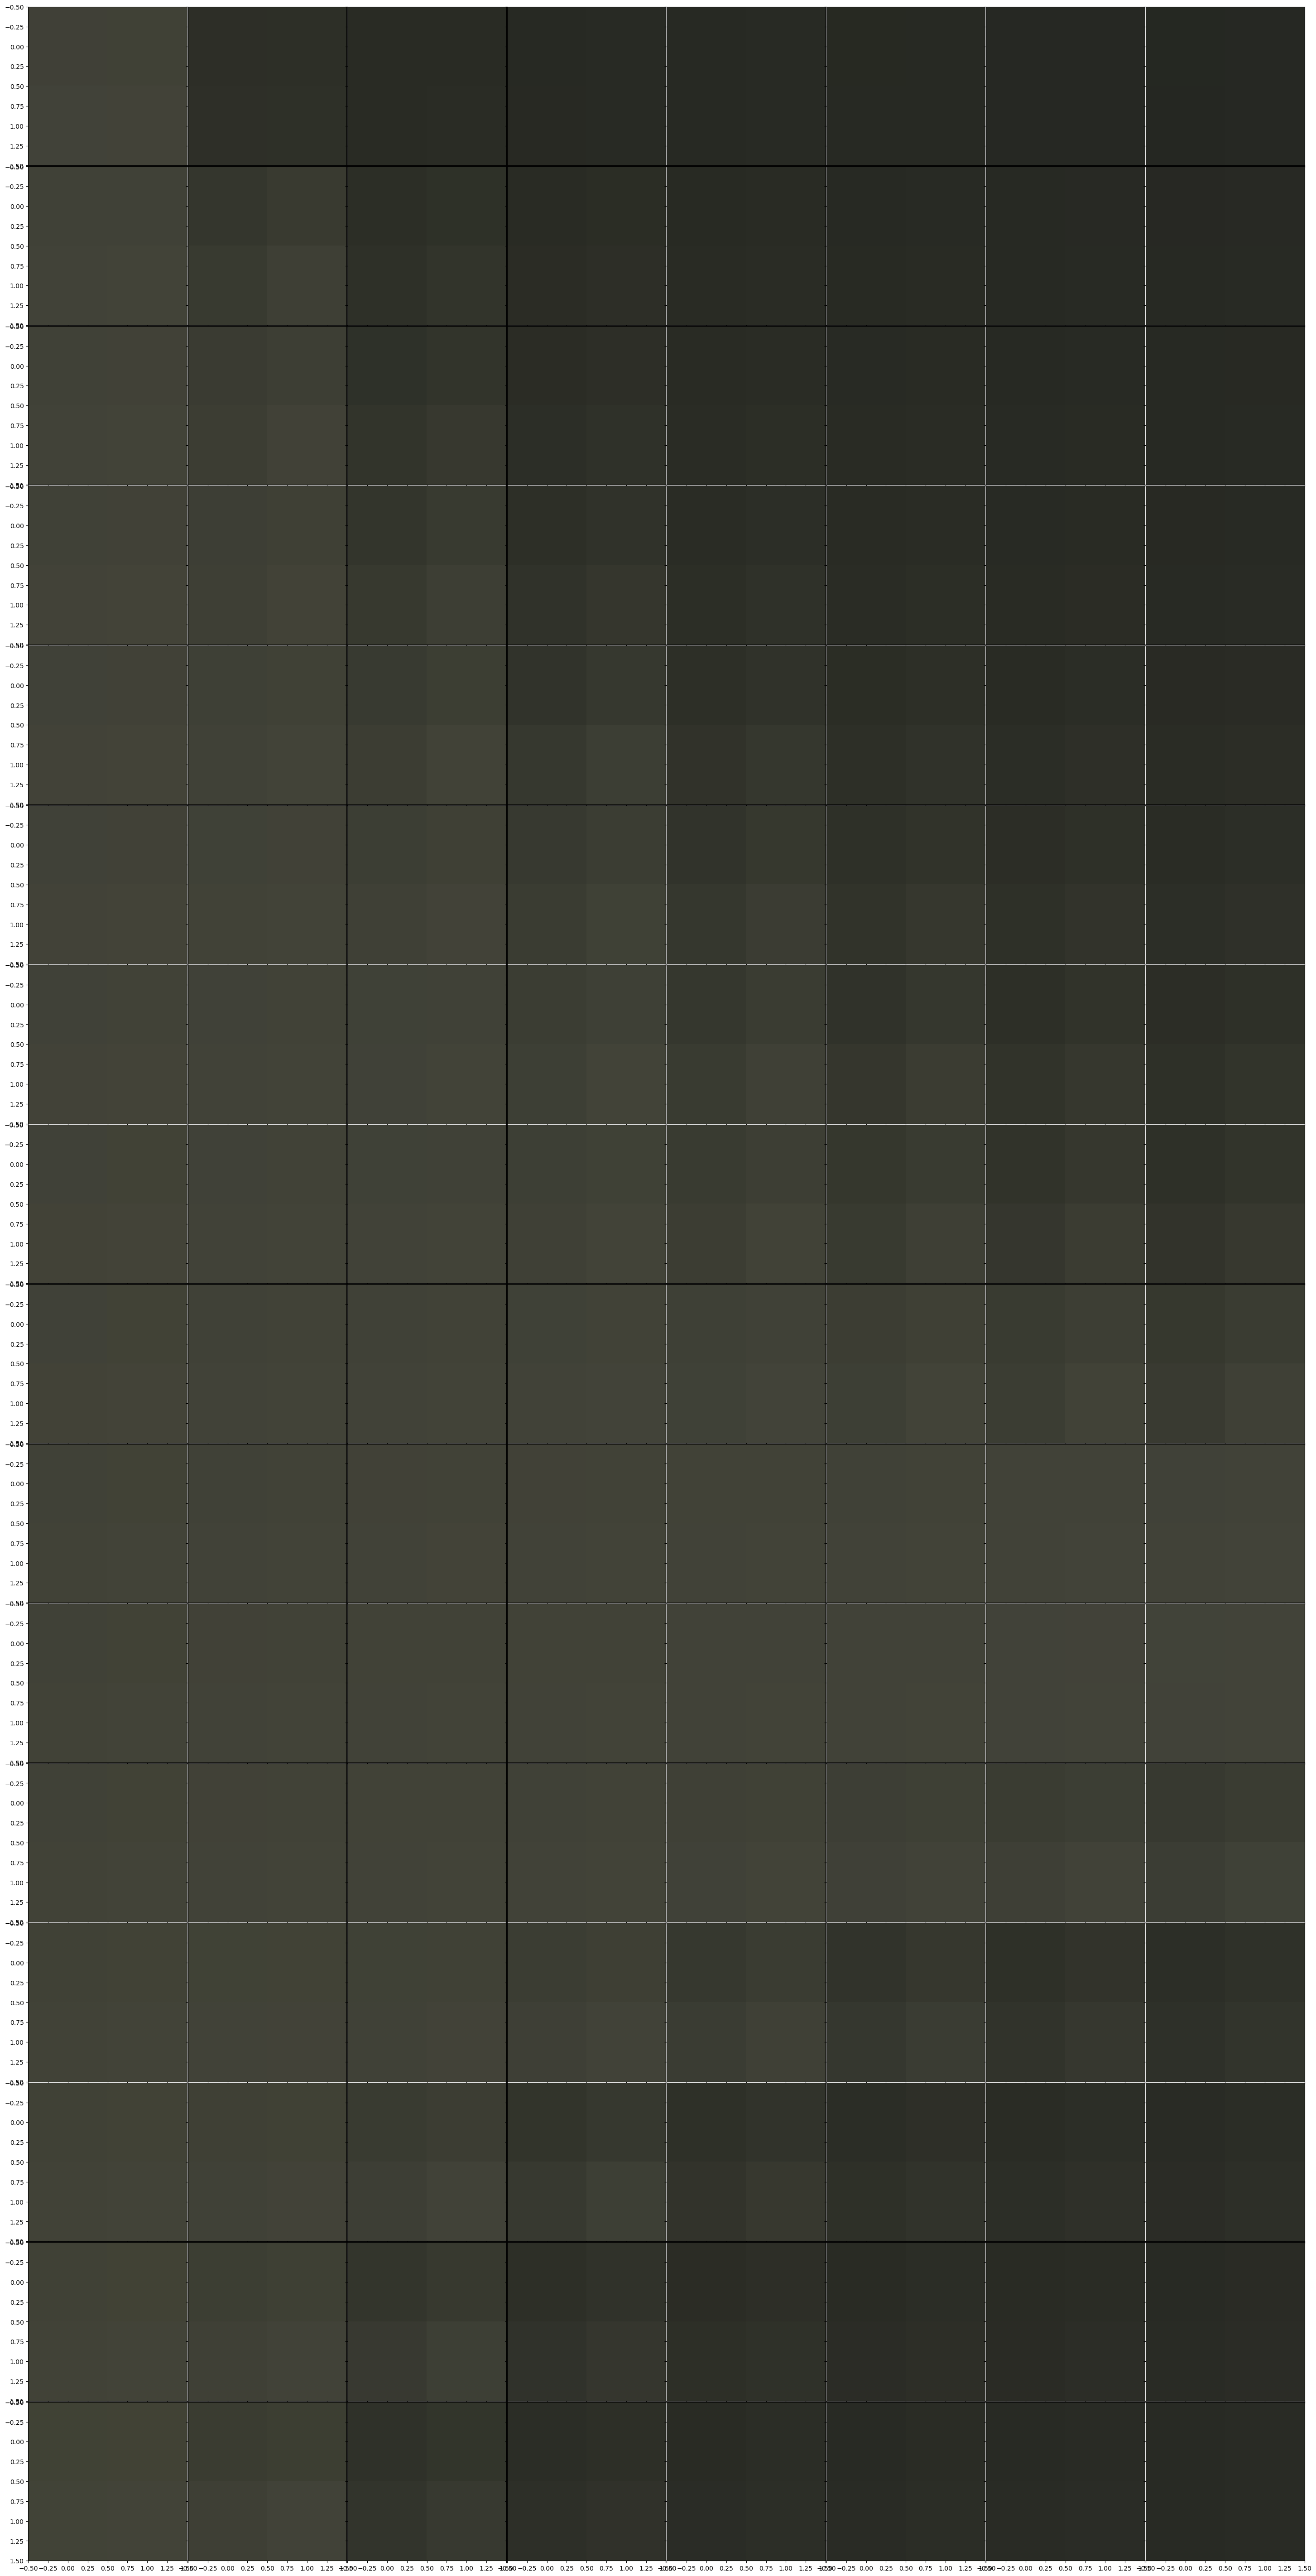

In [33]:
# displaying focal-aperture grid
fig = plt.figure(figsize=(80, 80))
im_grid = ImageGrid(fig, 121, (16,8))
grid_count = 0
for di in range(len(d_arr)) :
    for ai in range(len(sides_array)) :
        im_grid[grid_count].imshow(I_fas[180:182,460:462,:,di,ai])
        grid_count += 1
        
plt.show()